In [19]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Input files in the "New Cube Sensors" folder ---
cube1_file = "New Cube Sensors/25.05.02_CUBE 1 (mobile).csv"
cube6_file = "New Cube Sensors/25.05.02_CUBE 6.csv"
cube_ice_file = "New Cube Sensors/25.05.02_CUBE ICE.csv"

# --- Time ranges and corresponding file ---
time_slots = [
    ("09:00:00", "09:15:00", cube1_file),
    ("09:30:00", "09:45:00", cube_ice_file),
    ("09:50:00", "10:05:00", cube1_file),
    ("10:10:00", "10:25:00", cube6_file),
    ("10:30:00", "10:45:00", cube6_file),
    ("11:00:00", "11:15:00", cube1_file),
    ("11:15:00", "11:30:00", cube1_file),
]



In [10]:
# --- Helper: convert "HH:MM:SS" string to datetime.time object ---
def str_to_time(t_str):
    try:
        return datetime.strptime(t_str.strip(), "%H:%M:%S").time()
    except:
        return None



In [11]:
# --- Extract PMV values from a file within a time range ---
def get_pmv_for_range(file, start_str, end_str):
    df = pd.read_csv(file)

    # Use correct column names with leading spaces
    time_col = ' HH:MM:SS'
    pmv_col = ' PMV ASHRAE-55'

    # Convert time column to datetime.time objects
    df['__time_obj__'] = df[time_col].apply(str_to_time)

    # Convert bounds to time
    t_start = str_to_time(start_str)
    t_end = str_to_time(end_str)

    # Filter rows within time range
    df_valid = df[df['__time_obj__'].notna()]
    df_filtered = df_valid[
        (df_valid['__time_obj__'] >= t_start) &
        (df_valid['__time_obj__'] <= t_end)
    ]

    # Output raw time + PMV (with cleaned column names)
    return df_filtered[[time_col, pmv_col]].rename(
        columns={time_col: 'Time', pmv_col: 'PMV'}
    )



In [16]:
# --- Process all time slots ---
all_pmv = []

for start, end, file in time_slots:
    print(f"📂 Processing {file} from {start} to {end}")
    pmv_data = get_pmv_for_range(file, start, end)
    all_pmv.append(pmv_data)

# --- Normalize time strings to HH:MM ---
def normalize_to_HHMM(t_str):
    try:
        t = datetime.strptime(t_str.strip(), "%H:%M:%S")
        return t.strftime("%H:%M")
    except:
        return None

df_combined['Minute'] = df_combined['Time'].apply(normalize_to_HHMM)

# --- Drop rows with failed conversion ---
df_combined = df_combined[df_combined['Minute'].notna()]

# --- Ensure PMV is numeric ---
df_combined['PMV'] = pd.to_numeric(df_combined['PMV'], errors='coerce')

# --- Group by minute and compute mean ---
df_avg = df_combined.groupby('Minute')['PMV'].mean().reset_index()

# --- Sort as time ---
df_avg['Minute'] = pd.to_datetime(df_avg['Minute'], format="%H:%M")
df_avg = df_avg.sort_values('Minute')
df_avg['Minute'] = df_avg['Minute'].dt.strftime("%H:%M")

# --- Save ---
df_avg.to_csv("pmv_per_minute.csv", index=False)
print("✅ PMV per-minute with padded times saved to 'pmv_per_minute.csv'")





📂 Processing New Cube Sensors/25.05.02_CUBE 1 (mobile).csv from 09:00:00 to 09:15:00
📂 Processing New Cube Sensors/25.05.02_CUBE ICE.csv from 09:30:00 to 09:45:00
📂 Processing New Cube Sensors/25.05.02_CUBE 1 (mobile).csv from 09:50:00 to 10:05:00
📂 Processing New Cube Sensors/25.05.02_CUBE 6.csv from 10:10:00 to 10:25:00
📂 Processing New Cube Sensors/25.05.02_CUBE 6.csv from 10:30:00 to 10:45:00
📂 Processing New Cube Sensors/25.05.02_CUBE 1 (mobile).csv from 11:00:00 to 11:15:00
📂 Processing New Cube Sensors/25.05.02_CUBE 1 (mobile).csv from 11:15:00 to 11:30:00
✅ PMV per-minute with padded times saved to 'pmv_per_minute.csv'


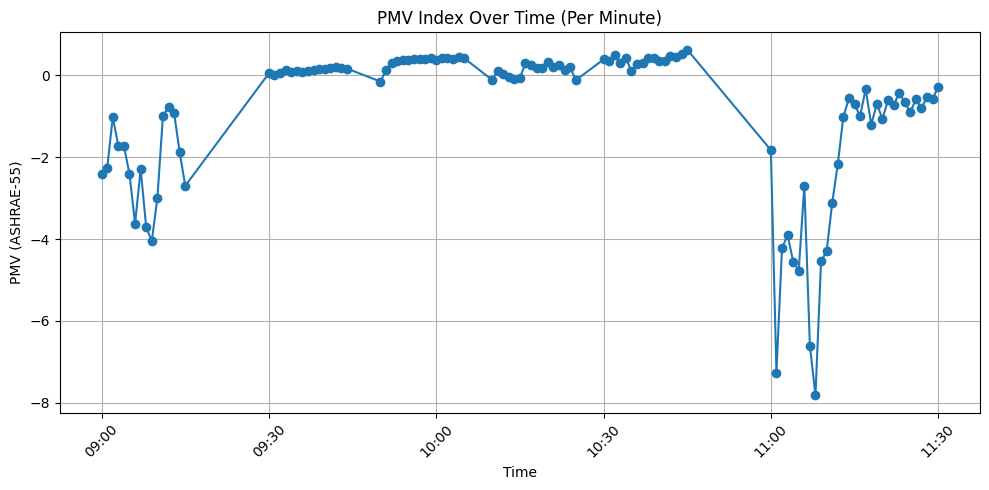

In [20]:
# --- Load the data ---
df = pd.read_csv("pmv_per_minute.csv")

# --- Convert to datetime for plotting ---
df['Minute'] = pd.to_datetime(df['Minute'], format="%H:%M")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df['Minute'], df['PMV'], marker='o', linestyle='-')

# --- Format the x-axis to show only HH:MM ---
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# --- Labels & style ---
plt.title("PMV Index Over Time (Per Minute)")
plt.xlabel("Time")
plt.ylabel("PMV (ASHRAE-55)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- Show the plot ---
plt.show()
